# SH 3st Catboost
## public : 1.0562971377 / private : 1.0271144458 / K-FOLD log_loss mean : 0.7712302544102928

왜 더 안좋아지냐고! 내가 이만큼 노력하는데 이놈들아!!!!

## 3nd 전처리

1. 2nd에서 encoder 실수가 있었음 
-숫자의 차이에서 의미를 가지면 ordinary 

-그 자체가 의미를 가진다면 one_hot or get_dummies

2. child 있으면 y 없으면 n

## 진행방향
1. reality + car
2. 하우스 타입 등 차원 줄이기
3. 스캐일링 해보지말까....? 진짜 돌겠네



In [75]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier #분류트리(모델) 
from sklearn.model_selection import train_test_split # train/test
from sklearn.metrics import accuracy_score, confusion_matrix # 평가 : 분류정확도 
from sklearn.metrics import classification_report # 평가 : 정확률, 재현율, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [9]:
#새로불러올때 이거불러오면 됨
train = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\train_1103.csv', index_col='Unnamed: 0')
test = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\test_1103.csv', index_col='Unnamed: 0')
#Raw data
train1 = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\235713_신용카드 사용자 연체 예측 AI 경진대회_data (1)\open\train.csv')
test1 = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\235713_신용카드 사용자 연체 예측 AI 경진대회_data (1)\open\test.csv')
#데이터 DAYS_EMPLOYED 드랍상태라 다시 가져와줌
#train['DAYS_EMPLOYED'] = train1['DAYS_EMPLOYED']
#test['DAYS_EMPLOYED'] = test1['DAYS_EMPLOYED']

In [ ]:
#test.drop(columns=['work_year_income','age_income'], inplace=True)
#train.drop(columns=['work_year_income','age_income'], inplace=True)

In [10]:
train.head(1)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,occyp_type,family_size,...,age_month,age_total,DAYS_EMPLOYED_MOD,work_year,work_month,work_total,ID,Nth_card,income_mean,contact_num
0,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,retired,2.0,...,699.0,57.42,0.0,0.0,0.0,0.0,0.0,3,51750.0,2


In [12]:
train1.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [ ]:
#일한경험이 있고 소득타입이 pensioner인데 직업이 있음 -> 은퇴로 감안하여 retired 처리 (할려고하다가 몇명 안되서 걍 무시 9명)
#print(train[(train['income_type']=='Pensioner') & (train['DAYS_EMPLOYED']!=365243) & (train['occyp_type']!='retired')]['occyp_type'].value_counts())
#train.loc[((train['income_type']=='Pensioner') & (train['DAYS_EMPLOYED']!=365243) & (train['occyp_type']!='retired')), 'occyp_type'] = 'retired'
#print(test[(test['income_type']=='Pensioner') & (test['DAYS_EMPLOYED']!=365243) & (test['occyp_type']!='retired')]['occyp_type'].value_counts())
#test.loc[((test['income_type']=='Pensioner') & (test['DAYS_EMPLOYED']!=365243) & (test['occyp_type']!='retired')), 'occyp_type'] = 'retired'

In [ ]:
q=train[(train['income_type']=='Pensioner')]['income_total'].value_counts().sort_values()

In [ ]:
train[(train['income_type']=='Pensioner') & (train['DAYS_EMPLOYED']!=365243) & (train['occyp_type']!='retired')].sort_values('income_total')
#print(train[(train['income_type']=='Pensioner') & (train['DAYS_EMPLOYED']!=365243) & (train['occyp_type']!='retired')]['occyp_type'].value_counts())

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,occyp_type,family_size,...,age_total,DAYS_EMPLOYED_MOD,work_year,work_month,work_total,ID,Nth_card,income_mean,contact_num,DAYS_EMPLOYED
14693,F,Y,Y,112500.00,Pensioner,Secondary / secondary special,Married,House / apartment,no data,2.00,...,54.08,-73.00,0.00,2.00,0.17,4777.00,1,56250.00,2,-706
6311,F,N,Y,157500.00,Pensioner,Higher education,Married,House / apartment,Medicine staff,2.00,...,31.25,-365.00,1.00,12.00,1.00,2065.00,1,78750.00,3,-2193
25260,M,Y,Y,157500.00,Pensioner,Secondary / secondary special,Married,House / apartment,Drivers,3.00,...,28.67,0.00,0.00,0.00,0.00,8385.00,1,52500.00,2,-110
1364,F,N,N,180000.00,Pensioner,Secondary / secondary special,Civil marriage,Municipal apartment,Laborers,2.00,...,54.75,0.00,0.00,0.00,0.00,472.00,1,90000.00,1,-3350
12880,F,N,Y,270000.00,Pensioner,Higher education,Single / not married,House / apartment,Core staff,3.00,...,25.58,-1665.00,4.00,55.00,4.50,4221.00,1,90000.00,1,-2757
15960,F,Y,Y,270000.00,Pensioner,Higher education,Married,House / apartment,Accountants,2.00,...,46.75,0.00,0.00,0.00,0.00,5181.00,1,135000.00,2,-109
13126,F,N,Y,292500.00,Pensioner,Secondary / secondary special,Married,House / apartment,Core staff,5.00,...,32.08,-42.00,0.00,1.00,0.08,4318.00,1,58500.00,1,-2207
13907,F,Y,N,315000.00,Pensioner,Higher education,Married,House / apartment,no data,2.00,...,34.17,0.00,0.00,0.00,0.00,4550.00,1,157500.00,3,-3255
14017,F,Y,N,450000.00,Pensioner,Higher education,Married,House / apartment,Managers,2.00,...,50.42,-4141.00,11.00,138.00,11.33,4582.00,1,225000.00,3,-203


In [144]:
train.drop(columns=['chind'],inplace=True)
test.drop(columns=['chind'],inplace=True)

In [154]:
#child 칼럼 생성 자식 있으면 Y 없으면 N
train['child'] = train1['child_num']
test['child'] = test1['child_num']

In [163]:
train.loc[train['child'] ==0, 'child'] = 'N'
train.loc[train['child'] != 'N', 'child'] = 'Y'
test.loc[test['child'] == 0, 'child'] = 'N'
test.loc[test['child'] != 'N', 'child'] = 'Y'
train['child'].value_counts()

N    18340
Y     8117
Name: child, dtype: int64

In [13]:
#추가 변수 생성 work_year_income = income/work_year 
a=train['income_total']/train['work_total']
train['work_year_income'] = round(a,2)
b=test['income_total']/test['work_total']
test['work_year_income']=round(b,2)

In [14]:
#work_year 0인 경우 work_year_income 0처리해줌 클러스터링할때 따로 처리해줄 예정
train.loc[train['work_total']==0, 'work_year_income'] = 0
test.loc[test['work_total']==0, 'work_year_income'] = 0

In [15]:
#추가 변수 생성 work_age_income = income/age
c = train['income_total']/train['age_total']
train['age_income'] = round(c,2)
d = test['income_total']/test['age_total']
test['age_income'] = round(d,2)


In [16]:
train.head(1)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,occyp_type,family_size,...,DAYS_EMPLOYED_MOD,work_year,work_month,work_total,ID,Nth_card,income_mean,contact_num,work_year_income,age_income
0,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,retired,2.0,...,0.0,0.0,0.0,0.0,0.0,3,51750.0,2,0.0,1802.51


In [23]:
pd.options.display.float_format = '{:.2f}'.format
e = train[train['work_year_income']>0].groupby(train['occyp_type']).mean().sort_values('work_year_income')
e= e[['income_total', 'work_total','work_year_income', 'age_total','age_income']]
f= e[['income_total','work_year_income', 'age_income']]
#f1= e[['income_total','work_year_income', 'age_income']]
f2= e[['income_total','work_year_income', 'age_income']]

In [ ]:
f

,income_total,work_year_income,age_income
occyp_type,,,
Secretaries,167810.13,50271.28,4222.43
Medicine staff,168039.50,56163.41,4236.80
Realty agents,247425.00,63974.43,6678.19
Low-skill Laborers,140310.00,87214.90,3768.45
Cooking staff,146251.27,90385.85,3913.94
HR staff,183681.82,92505.78,5293.01
Laborers,181080.25,98445.67,5039.56
Accountants,205898.90,99048.59,5500.89
Cleaning staff,147468.46,99388.16,3250.73


# 직업 클러스트 구분 (4개 채택)

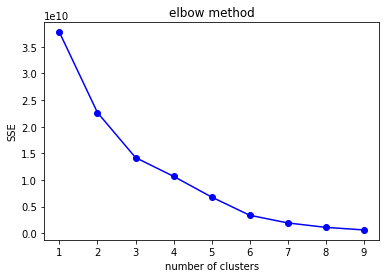

In [18]:
import matplotlib.pyplot as plt
def elbow(data, length):
    sse = [] # sum of squre error 오차제곱합
    for i in range(1, length):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(data)
        # SSE 값 저장
        sse.append(kmeans.inertia_)
    plt.plot(range(1, length), sse, 'bo-')
    plt.title("elbow method")
    plt.xlabel("number of clusters")
    plt.ylabel("SSE")
    plt.show()
elbow(f, 10)

In [19]:
from sklearn.metrics import silhouette_score, silhouette_samples
import seaborn as sns
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

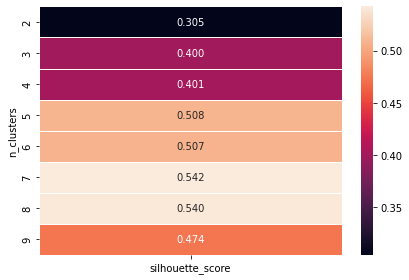

In [20]:
visualize_silhouette_layer(f)

## 밑에 스케일링 하다가 때려치고 걍 non scaler로 함 
non , minmax 둘다 클러스트링한 결과 육안으로는 차이 그렇게 크게 나지않는 것 같음 

시각화 실패

In [21]:
kmeans = KMeans(n_clusters= 4)
kmeans.fit(f)

kmeans.labels_

array([2, 2, 1, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 0, 0, 1, 0, 0, 0])

In [24]:
f2['non'] = kmeans.labels_
f2

,income_total,work_year_income,age_income,non
occyp_type,,,,
Secretaries,167810.13,50271.28,4222.43,2
Medicine staff,168039.50,56163.41,4236.80,2
Realty agents,247425.00,63974.43,6678.19,1
Low-skill Laborers,140310.00,87214.90,3768.45,2
Cooking staff,146251.27,90385.85,3913.94,2
HR staff,183681.82,92505.78,5293.01,3
Laborers,181080.25,98445.67,5039.56,3
Accountants,205898.90,99048.59,5500.89,3
Cleaning staff,147468.46,99388.16,3250.73,2


## MinMaxScaler

In [25]:
#작업 전 minmaxscaler 처리
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(f)
f_minmax = MinMaxScaler.transform(f)

In [26]:
MinMaxScaler.fit(f)

MinMaxScaler()

In [27]:
f_minmax

array([[0.19689265, 0.        , 0.23519635],
       [0.19853492, 0.04922853, 0.23867484],
       [0.76691123, 0.11448943, 0.82960354],
       [0.        , 0.30866279, 0.12531327],
       [0.04253772, 0.33515601, 0.16052845],
       [0.31052919, 0.35286794, 0.49432522],
       [0.29190277, 0.40249555, 0.43297957],
       [0.46959681, 0.40753297, 0.5446418 ],
       [0.05125243, 0.41037006, 0.        ],
       [0.36401433, 0.43583529, 0.47817979],
       [0.37012113, 0.45941191, 0.5229121 ],
       [0.42121795, 0.46487769, 0.51548086],
       [0.45716516, 0.4804145 , 0.47656582],
       [0.12071057, 0.59547685, 0.3626833 ],
       [0.25086603, 0.64110103, 0.42572029],
       [1.        , 0.66948547, 1.        ],
       [0.51075173, 0.71754692, 0.58195279],
       [0.48947904, 0.82116114, 0.84535691],
       [0.34283811, 1.        , 0.29840349]])

In [28]:
kmeans = KMeans(n_clusters= 4)
kmeans.fit(f_minmax)

kmeans.labels_

array([1, 1, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2])

In [29]:
f2['minmax'] = kmeans.labels_
f2

,income_total,work_year_income,age_income,non,minmax
occyp_type,,,,,
Secretaries,167810.13,50271.28,4222.43,2,1
Medicine staff,168039.50,56163.41,4236.80,2,1
Realty agents,247425.00,63974.43,6678.19,1,0
Low-skill Laborers,140310.00,87214.90,3768.45,2,1
Cooking staff,146251.27,90385.85,3913.94,2,1
HR staff,183681.82,92505.78,5293.01,3,2
Laborers,181080.25,98445.67,5039.56,3,2
Accountants,205898.90,99048.59,5500.89,3,2
Cleaning staff,147468.46,99388.16,3250.73,2,1


## RobustScaler

In [ ]:
# from sklearn.preprocessing import RobustScaler
# robust = RobustScaler()

# f_robust = robust.fit_transform(f)
# f_robust

array([[-0.54935446, -1.58903353, -0.91001165],
       [-0.54317275, -1.40954877, -0.89689702],
       [ 1.59625695, -1.17161084,  1.33102346],
       [-1.29047962, -0.46366454, -1.32429303],
       [-1.13036306, -0.36707159, -1.19152471],
       [-0.12161425, -0.30249476,  0.06695651],
       [-0.19172612, -0.12155501, -0.16432895],
       [ 0.47713343, -0.10318884,  0.25666019],
       [-1.09755993, -0.09284496, -1.79674936],
       [ 0.07970958,  0.        ,  0.00608497],
       [ 0.10269624,  0.08595916,  0.17473484],
       [ 0.29503019,  0.10588713,  0.14671754],
       [ 0.43033936,  0.16253355,  0.        ],
       [-0.83611203,  0.5820451 , -0.42936009],
       [-0.34619284,  0.74838854, -0.19169793],
       [ 2.47362823,  0.8518768 ,  1.97345252],
       [ 0.63204499,  1.02710641,  0.39733016],
       [ 0.55197227,  1.40487864,  1.39041686],
       [ 0.        ,  2.05691613, -0.67170795]])

In [ ]:
# kmeans = KMeans(n_clusters= 7)
# kmeans.fit(f_robust)

# kmeans.labels_

array([4, 4, 6, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 0, 0, 2, 5, 5, 0])

In [ ]:
# f1['robust'] = kmeans.labels_
# f1

,income_total,work_year_income,age_income,minmax,robust,standard
occyp_type,,,,,,
Secretaries,167810.13,50271.28,4222.43,1,4,1
Medicine staff,168039.50,56163.41,4236.80,1,4,1
Realty agents,247425.00,63974.43,6678.19,3,6,6
Low-skill Laborers,140310.00,87214.90,3768.45,5,1,4
Cooking staff,146251.27,90385.85,3913.94,5,1,4
HR staff,183681.82,92505.78,5293.01,2,3,0
Laborers,181080.25,98445.67,5039.56,2,3,0
Accountants,205898.90,99048.59,5500.89,2,3,0
Cleaning staff,147468.46,99388.16,3250.73,5,1,4


## Standard Scaler

In [ ]:
# from sklearn.preprocessing import StandardScaler
# standardScaler = StandardScaler()
# f_standard = standardScaler.fit_transform(f)
# f_standard

array([[-0.63948773, -1.86015776, -0.87467114],
       [-0.63264091, -1.65938912, -0.86057084],
       [ 1.73697719, -1.39323573,  1.53479636],
       [-1.46035302, -0.60133886, -1.3200892 ],
       [-1.28300899, -0.49329162, -1.17734224],
       [-0.16572552, -0.42105705,  0.17572429],
       [-0.24338096, -0.21866087, -0.0729442 ],
       [ 0.49744343, -0.19811678,  0.37968577],
       [-1.24667645, -0.1865463 , -1.82805454],
       [ 0.05725942, -0.08269148,  0.11027774],
       [ 0.08271929,  0.013461  ,  0.29160305],
       [ 0.29574709,  0.03575209,  0.26148002],
       [ 0.44561463,  0.09911583,  0.10373544],
       [-0.9570985 ,  0.56837442, -0.35789462],
       [-0.41446727,  0.7544434 , -0.10237018],
       [ 2.70874779,  0.87020363,  2.22550929],
       [ 0.66902244,  1.06621254,  0.53092826],
       [ 0.58033443,  1.48878223,  1.59865367],
       [-0.03102638,  2.21814044, -0.61845694]])

In [ ]:
# kmeans = KMeans(n_clusters= 7)
# kmeans.fit(f_standard)

# kmeans.labels_

array([1, 1, 6, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 3, 3, 2, 5, 5, 3])

In [ ]:
# f1['standard'] = kmeans.labels_
# f1

,income_total,work_year_income,age_income,minmax,robust,standard
occyp_type,,,,,,
Secretaries,167810.13,50271.28,4222.43,1,3,1
Medicine staff,168039.50,56163.41,4236.80,1,3,1
Realty agents,247425.00,63974.43,6678.19,3,4,6
Low-skill Laborers,140310.00,87214.90,3768.45,5,1,4
Cooking staff,146251.27,90385.85,3913.94,5,1,4
HR staff,183681.82,92505.78,5293.01,2,0,0
Laborers,181080.25,98445.67,5039.56,2,0,0
Accountants,205898.90,99048.59,5500.89,2,0,0
Cleaning staff,147468.46,99388.16,3250.73,5,1,4


In [ ]:
f2

,income_total,work_year_income,age_income,non,minmax
occyp_type,,,,,
Secretaries,167810.13,50271.28,4222.43,0,2
Medicine staff,168039.50,56163.41,4236.80,0,2
Realty agents,247425.00,63974.43,6678.19,1,0
Low-skill Laborers,140310.00,87214.90,3768.45,0,2
Cooking staff,146251.27,90385.85,3913.94,0,2
HR staff,183681.82,92505.78,5293.01,3,1
Laborers,181080.25,98445.67,5039.56,3,1
Accountants,205898.90,99048.59,5500.89,3,1
Cleaning staff,147468.46,99388.16,3250.73,0,2


In [30]:
print(f2[f2['non']== 0].index)
print(f2[f2['non']== 1].index)
print(f2[f2['non']== 2].index)
print(f2[f2['non']== 3].index)

Index(['Waiters/barmen staff', 'Sales staff', 'Drivers', 'IT staff',
       'Security staff'],
      dtype='object', name='occyp_type')
Index(['Realty agents', 'Managers'], dtype='object', name='occyp_type')
Index(['Secretaries', 'Medicine staff', 'Low-skill Laborers', 'Cooking staff',
       'Cleaning staff'],
      dtype='object', name='occyp_type')
Index(['HR staff', 'Laborers', 'Accountants', 'no data', 'Core staff',
       'High skill tech staff', 'Private service staff'],
      dtype='object', name='occyp_type')


In [31]:
#occyp_type 클러스트로 대체 완
train['occyp_type'] = train['occyp_type'].replace('retired' , 'A')
train['occyp_type'] = train['occyp_type'].replace(['Secretaries', 'Medicine staff', 'Low-skill Laborers', 'Cooking staff',
       'Cleaning staff'], 'B')
train['occyp_type'] = train['occyp_type'].replace(['Realty agents', 'Managers'], 'C')
train['occyp_type'] = train['occyp_type'].replace(['Drivers', 'IT staff', 'Security staff'], 'D')
train['occyp_type'] = train['occyp_type'].replace(['HR staff', 'Laborers', 'Accountants', 'no data', 'Core staff',
       'High skill tech staff', 'Private service staff', 'Waiters/barmen staff', 'Sales staff'], 'E')


In [32]:
test['occyp_type'] = test['occyp_type'].replace('retired' , 'A')
test['occyp_type'] = test['occyp_type'].replace(['Secretaries', 'Medicine staff', 'Low-skill Laborers', 'Cooking staff',
       'Cleaning staff'], 'B')
test['occyp_type'] = test['occyp_type'].replace(['Realty agents', 'Managers'], 'C')
test['occyp_type'] = test['occyp_type'].replace(['Drivers', 'IT staff', 'Security staff'], 'D')
test['occyp_type'] = test['occyp_type'].replace(['HR staff', 'Laborers', 'Accountants', 'no data', 'Core staff',
       'High skill tech staff', 'Private service staff', 'Waiters/barmen staff', 'Sales staff'], 'E')

In [33]:
#train['family_type'] couple / single로 구분
train['family_type'] = train['family_type'].replace(['Married', 'Civil marriage'] , 'couple')
train['family_type'] = train['family_type'].replace(['Single / not married', 'Separated', 'Widow'], 'single')

In [34]:
test['family_type'] = test['family_type'].replace(['Married', 'Civil marriage'] , 'couple')
test['family_type'] = test['family_type'].replace(['Single / not married', 'Separated', 'Widow'], 'single')

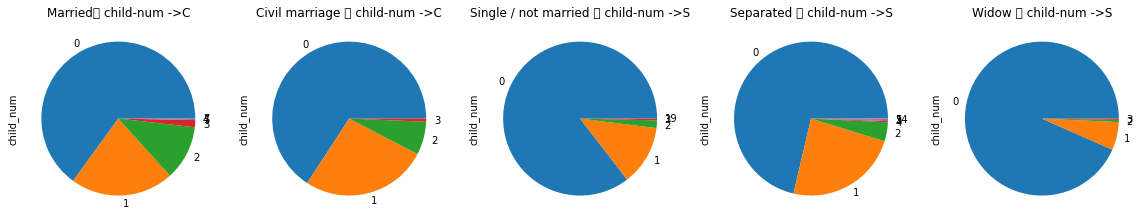

In [46]:
#그래프
plt.figure(figsize=(20, 6))
plt.subplot(151)
plt.title('Married별 child-num ->C')
train1[train1['family_type']=='Married']['child_num'].value_counts(normalize=True).plot(kind='pie')
plt.subplot(152)
plt.title('Civil marriage 별 child-num ->C')
train1[train1['family_type']=='Civil marriage']['child_num'].value_counts(normalize=True).plot(kind='pie')
plt.subplot(153)
plt.title('Single / not married 별 child-num ->S')
train1[train1['family_type']=='Single / not married']['child_num'].value_counts(normalize=True).plot(kind='pie')
plt.subplot(154)
plt.title('Separated 별 child-num ->S')
train1[train1['family_type']=='Separated']['child_num'].value_counts(normalize=True).plot(kind='pie')
plt.subplot(155)
plt.title('Widow 별 child-num ->S')
train1[train1['family_type']=='Widow']['child_num'].value_counts(normalize=True).plot(kind='pie')
plt.show()

In [47]:
#학생 7명 중 4명의 occyp_type상태가 core staff.
print(train['income_type'].value_counts())
train1[(train1['income_type']=='Student') & (train1['occyp_type']=='Core staff')]

Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
2990,2990,F,N,Y,0,171000.00,Student,Higher education,Married,House / apartment,-18756,-3904,1,0,0,1,Core staff,2.00,-60.00,2.00
3602,3602,F,N,Y,0,171000.00,Student,Higher education,Married,House / apartment,-18756,-3904,1,0,0,1,Core staff,2.00,-39.00,1.00
8936,8936,F,N,Y,0,171000.00,Student,Higher education,Married,House / apartment,-18756,-3904,1,0,0,1,Core staff,2.00,-39.00,1.00
21681,21681,F,N,Y,0,171000.00,Student,Higher education,Married,House / apartment,-18756,-3904,1,0,0,1,Core staff,2.00,-35.00,1.00


In [48]:
#Student 전부 working으로 편입 -> 편입됨 확인
train['income_type'] = train['income_type'].replace('Student', 'Working')
print(train['income_type'].value_counts())
test['income_type'] = test['income_type'].replace('Student', 'Working')

Working                 13652
Commercial associate     6202
Pensioner                4449
State servant            2154
Name: income_type, dtype: int64


In [49]:
#family_size single, couple, fam, bigfam으로 구분
print(train['family_size'].value_counts())
train['family_size'] = train['family_size'].replace(1, 'single')
train['family_size'] = train['family_size'].replace(2, 'couple')
train['family_size'] = train['family_size'].replace([3,4], 'family')
train['family_size'] = train['family_size'].replace([5,6], 'big family')



2.00    14121
1.00     5109
3.00     4632
4.00     2260
5.00      291
6.00       44
Name: family_size, dtype: int64


In [50]:
#------------------------------------------------------------------------
test['family_size'] = test['family_size'].replace(1, 'single')
test['family_size'] = test['family_size'].replace(2, 'couple')
test['family_size'] = test['family_size'].replace([3,4], 'family')
test['family_size'] = test['family_size'].replace([5,6], 'big family')

In [ ]:
train.head(1)

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type,family_size,credit,ID,scal_begin_month,scal_age_total,scal_work_total,scal_contact_num,scal_Nth_card,scal_income_total,scal_income_mean,scal_age_income,scal_work_year_income
0,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,0.00,0.00,0.60,0.79,0.00,0.33,0.06,0.05,0.05,0.02,0.00


In [ ]:
test['house_type'].value_counts()

House / apartment      8895
With parents            519
Municipal apartment     310
Rented apartment        146
Office apartment         72
Co-op apartment          58
Name: house_type, dtype: int64

In [ ]:
def birth_catagory(value):
    ep = ''
    if value <= 30: ep = 'A'
    elif value <= 40: ep = 'B'
    elif value <= 50: ep = 'C'
    elif value <= 60: ep = 'D'
    elif value < 70: ep = 'E'
       
    return ep

In [ ]:
train.head(1)

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type,family_size,credit,ID,scal_begin_month,scal_age_total,scal_work_total,scal_contact_num,scal_Nth_card,scal_income_total,scal_income_mean,scal_age_income,scal_work_year_income
0,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,0.00,0.00,0.60,0.79,0.00,0.33,0.06,0.05,0.05,0.02,0.00


In [ ]:
train1.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [ ]:
train['edu_type'].value_counts()

Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: edu_type, dtype: int64

In [ ]:
len(train.columns)

20

In [ ]:
len(test.columns)

19

In [51]:
#변수 drop
test.drop(columns=['DAYS_BIRTH_MOD','age_year','DAYS_BIRTH_MOD','age_year','age_month','DAYS_EMPLOYED_MOD', 'work_year', 'work_month'], inplace=True)
train.drop(columns=['DAYS_BIRTH_MOD','age_year','DAYS_BIRTH_MOD','age_year','age_month','DAYS_EMPLOYED_MOD', 'work_year', 'work_month'], inplace=True)

In [ ]:
#train.to_csv('train-1차 전처리.csv')
#test.to_csv('test-1차 전처리.csv')

In [ ]:
#train_new = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\train-1차 전처리.csv')
#test_new = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\test-1차 전처리.csv')
train = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\train-1차 전처리.csv')
test = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\test-1차 전처리.csv')

# minmax scaling

In [ ]:
train.head(3)

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type,family_size,begin_month,credit,age_total,work_total,ID,Nth_card,contact_num,scal_income_total,scal_income_mean,scal_age_income,scal_work_year_income
0,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,-24.00,0.00,57.42,0.00,0.00,3,2,0.05,0.05,0.02,0.00
1,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,-28.00,0.00,57.08,0.00,0.00,2,2,0.05,0.05,0.02,0.00
2,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,-30.00,2.00,57.00,0.00,0.00,1,2,0.05,0.05,0.02,0.00


In [57]:
#numeric_train=train[['begin_month', 'age_total','work_total','contact_num','Nth_card']]
#numeric_test=test[['begin_month', 'age_total','work_total','contact_num','Nth_card']]
numeric_train
income_train = train[['income_total', 'income_mean', 'age_income','work_year_income']]
income_test = test[['income_total', 'income_mean', 'age_income','work_year_income']]


,begin_month,age_total,work_total,contact_num,Nth_card
0,-24.00,57.42,0.00,2,3
1,-28.00,57.08,0.00,2,2
2,-30.00,57.00,0.00,2,1
3,-17.00,65.83,0.00,1,2
4,-39.00,64.00,0.00,1,1
...,...,...,...,...,...
26452,-24.00,36.75,0.00,1,1
26453,-19.00,29.58,5.92,1,4
26454,-21.00,29.42,5.75,1,3
26455,-46.00,27.33,3.67,1,2


In [58]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(numeric_train)
train[['scal_begin_month', 'scal_age_total', 'scal_work_total', 'scal_contact_num','scal_Nth_card']] = MinMaxScaler.transform(numeric_train)
train.drop(columns=['begin_month', 'age_total','work_total','contact_num','Nth_card'], inplace=True)

KeyError: "['begin_month' 'age_total' 'work_total' 'contact_num' 'Nth_card'] not found in axis"

In [54]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(numeric_test)
test[['scal_begin_month', 'scal_age_total', 'scal_work_total', 'scal_contact_num','scal_Nth_card']] = MinMaxScaler.transform(numeric_test)
test.drop(columns=['begin_month', 'age_total','work_total','contact_num','Nth_card'], inplace=True)

In [59]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(income_train)
train[['scal_income_total', 'scal_income_mean', 'scal_age_income', 'scal_work_year_income']] = MinMaxScaler.transform(income_train)
train.drop(columns=['income_total', 'income_mean', 'age_income','work_year_income'], inplace=True)

In [60]:
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(income_test)
test[['scal_income_total', 'scal_income_mean', 'scal_age_income','scal_work_year_income']] = MinMaxScaler.transform(income_test)
test.drop(columns=['income_total', 'income_mean', 'age_income','work_year_income'], inplace=True)


(26457, 18)


<AxesSubplot:>

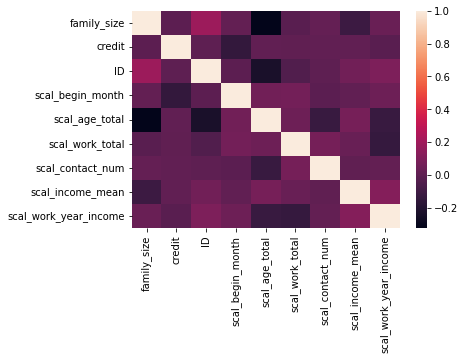

In [165]:
#heapmap 확인 후 다중공선성 우려되는 칼럼 삭제
#train.drop(columns=['scal_income_total','scal_age_income','scal_Nth_card'], inplace=True)
#test.drop(columns=['scal_income_total','scal_age_income','scal_Nth_card'], inplace=True)
print(train.shape)
sns.heatmap(train.corr())


In [ ]:
#numerical_feats.remove('income_total')
#numerical_feats.remove('credit')
#scaler = StandardScaler()
#train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
#test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
# numeric_list = ['income_mean','income_total', 'work_total', 'age_total', 'begin_month']
# len(train.columns.values)
# # != numeric_list
# object_list = []
# for i in len(train.columns.values):
#     if (train.columns.values[i] != numeric_list) == False
#     object_list.append(i)
    
    
    
# #train.columns.values[0] != numeric_list
# #if train.columns
# #numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()

SyntaxError: invalid syntax (Temp/ipykernel_19496/3234435170.py, line 6)

In [69]:
train.head(1)
train.columns

Index(['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'occyp_type', 'family_size', 'credit', 'ID',
       'scal_begin_month', 'scal_age_total', 'scal_work_total',
       'scal_contact_num', 'scal_Nth_card', 'scal_income_total',
       'scal_income_mean', 'scal_age_income', 'scal_work_year_income'],
      dtype='object')

## 인코딩

In [ ]:
#train.drop(columns=['scal_income_total','scal_age_income','scal_Nth_card'], inplace=True)

In [136]:
train.columns

Index(['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'occyp_type', 'family_size', 'credit', 'ID',
       'scal_begin_month', 'scal_age_total', 'scal_work_total',
       'scal_contact_num', 'scal_income_mean', 'scal_work_year_income'],
      dtype='object')

In [167]:
#ordinary: 숫자 크기변화의 의미가 있는 것 
ordinary_feats = ['scal_begin_month', 'scal_work_total',
                   'scal_contact_num', 'scal_income_mean', 'scal_work_year_income','family_size','scal_age_total','child']
#one-hot: 변수값들 사이의 크기가 의미가 없다
dummies_feats = ['gender', 'car', 'reality', 'income_type', 'edu_type','family_type', 'house_type', 'occyp_type', 'ID']

In [168]:
#OrdinalEncoder
from category_encoders.ordinal import OrdinalEncoder
encoder = OrdinalEncoder(ordinary_feats)
train[ordinary_feats] = encoder.fit_transform(train[ordinary_feats], train['credit'])
test[ordinary_feats] = encoder.fit_transform(test[ordinary_feats])

In [181]:
train

,family_size,credit,ID,scal_begin_month,scal_age_total,scal_work_total,scal_contact_num,scal_income_mean,scal_work_year_income,child,...,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents,occyp_type_A,occyp_type_B,occyp_type_C,occyp_type_D,occyp_type_E
0,1,0.00,0.00,0.60,0.79,0.00,0.33,0.05,0.00,1,...,1,0,0,0,0,1,0,0,0,0
1,1,0.00,0.00,0.53,0.78,0.00,0.33,0.05,0.00,2,...,1,0,0,0,0,1,0,0,0,0
2,1,2.00,0.00,0.50,0.78,0.00,0.33,0.05,0.00,1,...,1,0,0,0,0,1,0,0,0,0
3,2,2.00,1.00,0.72,0.96,0.00,0.00,0.11,0.00,1,...,1,0,0,0,0,1,0,0,0,0
4,2,2.00,1.00,0.35,0.92,0.00,0.00,0.11,0.00,1,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,4,2.00,8757.00,0.60,0.36,0.00,0.00,0.05,0.00,2,...,1,0,0,0,0,0,0,0,0,1
26453,1,1.00,8758.00,0.68,0.22,0.14,0.00,0.10,0.01,2,...,0,0,0,0,0,0,0,1,0,0
26454,1,1.00,8758.00,0.65,0.21,0.14,0.00,0.10,0.01,1,...,0,0,0,0,0,0,0,1,0,0
26455,1,0.00,8758.00,0.23,0.17,0.09,0.00,0.10,0.01,1,...,0,0,0,0,0,0,0,1,0,0


In [187]:
test

,family_size,ID,scal_begin_month,scal_age_total,scal_work_total,scal_contact_num,scal_income_mean,scal_work_year_income,child,gender_F,...,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents,occyp_type_A,occyp_type_B,occyp_type_C,occyp_type_D,occyp_type_E
0,1,0.00,0.95,0.82,0.00,0.33,0.05,0.00,1,1,...,1,0,0,0,0,1,0,0,0,0
1,1,0.00,0.23,0.75,0.00,0.33,0.05,0.00,1,1,...,1,0,0,0,0,1,0,0,0,0
2,1,0.00,0.12,0.74,0.00,0.33,0.05,0.00,1,1,...,1,0,0,0,0,1,0,0,0,0
3,2,1.00,0.53,0.94,0.00,0.00,0.11,0.00,1,1,...,1,0,0,0,0,1,0,0,0,0
4,1,2.00,0.82,0.72,0.00,0.00,0.05,0.00,1,1,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4,5583.00,0.88,0.36,0.12,0.00,0.00,0.00,1,0,...,1,0,0,0,0,0,0,0,0,1
9996,1,5584.00,0.97,0.24,0.18,0.00,0.10,0.00,1,0,...,0,0,0,0,0,0,0,1,0,0
9997,1,5584.00,0.57,0.20,0.13,0.00,0.10,0.00,1,0,...,0,0,0,0,0,0,0,1,0,0
9998,1,5584.00,0.38,0.18,0.11,0.00,0.10,0.00,1,0,...,0,0,0,0,0,0,0,1,0,0


In [185]:
#pd.get_dummies(fruit, columns = ['name'])
train = pd.get_dummies(train,columns=['gender', 'car', 'reality', 'income_type', 'edu_type','family_type', 'house_type', 'occyp_type'])
test = pd.get_dummies(test,columns=['gender', 'car', 'reality', 'income_type', 'edu_type','family_type', 'house_type', 'occyp_type'])

In [188]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [111]:
#train = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\train_final.csv', index_col='Unnamed: 0')
#test = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\test_final.csv',index_col='Unnamed: 0')

In [89]:
#인코딩하던중 저장 1104 06:38
#train.to_csv('train_final.csv')
#test.to_csv('test_final.csv')
#train_final = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\train_final.csv')
#test_final = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\test_final.csv')

In [189]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
cat_clf=CatBoostClassifier()
cat_clf.fit(X_train, y_train)
y_pred=cat_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(cat_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cat_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Learning rate set to 0.092151
0:	learn: 1.0473291	total: 21.6ms	remaining: 21.6s
1:	learn: 1.0067740	total: 28.4ms	remaining: 14.2s
2:	learn: 0.9737887	total: 34.4ms	remaining: 11.4s
3:	learn: 0.9468016	total: 42ms	remaining: 10.5s
4:	learn: 0.9246508	total: 47.9ms	remaining: 9.53s
5:	learn: 0.9059759	total: 55.3ms	remaining: 9.17s
6:	learn: 0.8904944	total: 59.8ms	remaining: 8.49s
7:	learn: 0.8777577	total: 67ms	remaining: 8.31s
8:	learn: 0.8671310	total: 74.2ms	remaining: 8.17s
9:	learn: 0.8580739	total: 80ms	remaining: 7.92s
10:	learn: 0.8505178	total: 86.7ms	remaining: 7.79s
11:	learn: 0.8437268	total: 92.8ms	remaining: 7.64s
12:	learn: 0.8381206	total: 98.7ms	remaining: 7.49s
13:	learn: 0.8331374	total: 105ms	remaining: 7.39s
14:	learn: 0.8289348	total: 111ms	remaining: 7.26s
15:	learn: 0.8253918	total: 116ms	remaining: 7.16s
16:	learn: 0.8225412	total: 121ms	remaining: 7.02s
17:	learn: 0.8201396	total: 127ms	remaining: 6.9s
18:	learn: 0.8181070	total: 132ms	remaining: 6.8s
19:	le

<AxesSubplot:>

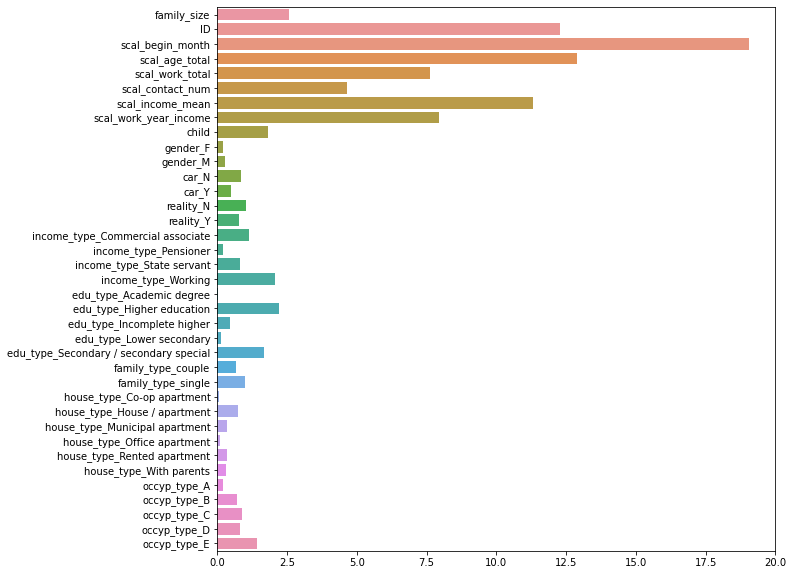

In [190]:
# 특성 중요도 시각화
import seaborn as sns
plt.figure(figsize=(10,10))
feature_names = list(train_x.columns)
sns.barplot(cat_clf.feature_importances_, y=feature_names)

<AxesSubplot:>

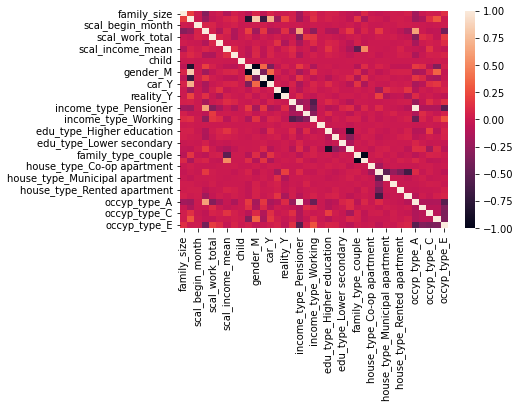

In [192]:
sns.heatmap(train_x.corr())

In [193]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(cat_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        cat_clf.fit(X_train, y_train)
        
        predictions=cat_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=cat_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_clf)

Learning rate set to 0.092455
0:	learn: 1.0468396	total: 8.22ms	remaining: 8.21s
1:	learn: 1.0060774	total: 14.2ms	remaining: 7.11s
2:	learn: 0.9729760	total: 20.4ms	remaining: 6.78s
3:	learn: 0.9456933	total: 27.1ms	remaining: 6.74s
4:	learn: 0.9235247	total: 33.3ms	remaining: 6.63s
5:	learn: 0.9047694	total: 40.6ms	remaining: 6.73s
6:	learn: 0.8891817	total: 47ms	remaining: 6.67s
7:	learn: 0.8759099	total: 53.2ms	remaining: 6.59s
8:	learn: 0.8656571	total: 59.2ms	remaining: 6.52s
9:	learn: 0.8565741	total: 65.4ms	remaining: 6.47s
10:	learn: 0.8489687	total: 72.1ms	remaining: 6.48s
11:	learn: 0.8423270	total: 78ms	remaining: 6.42s
12:	learn: 0.8369640	total: 85.7ms	remaining: 6.5s
13:	learn: 0.8319133	total: 92.5ms	remaining: 6.52s
14:	learn: 0.8277260	total: 99.8ms	remaining: 6.55s
15:	learn: 0.8241773	total: 107ms	remaining: 6.57s
16:	learn: 0.8215395	total: 114ms	remaining: 6.6s
17:	learn: 0.8192488	total: 121ms	remaining: 6.59s
18:	learn: 0.8171853	total: 127ms	remaining: 6.58s
19

In [194]:
my_submission

array([[0.16248989, 0.81769628, 0.01981383],
       [0.09374712, 0.16116734, 0.74508554],
       [0.09122015, 0.18969429, 0.71908556],
       ...,
       [0.18084836, 0.18287434, 0.63627731],
       [0.16599631, 0.16620806, 0.66779563],
       [0.17635408, 0.07547174, 0.74817418]])

In [196]:
submission = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\235713_신용카드 사용자 연체 예측 AI 경진대회_data (1)\open\sample_submission.csv')

In [197]:
submission.loc[:,1:]=my_submission

In [ ]:
submission

,index,0,1,2
0,26457,0.20,0.78,0.02
1,26458,0.11,0.21,0.67
2,26459,0.12,0.16,0.72
3,26460,0.12,0.14,0.74
4,26461,0.04,0.11,0.85
...,...,...,...,...
9995,36452,0.12,0.15,0.73
9996,36453,0.24,0.74,0.02
9997,36454,0.18,0.15,0.67
9998,36455,0.16,0.13,0.71


In [199]:
submission.to_csv('1104cat3_submission.csv', index=False)

# StandardScaler 

In [ ]:
#numerical_feats.remove('income_total')
#numerical_feats.remove('credit')
#scaler = StandardScaler()
#train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
#test[numerical_feats] = scaler.transform(test[numerical_feats])